#MMDetection

In [ ]:
from mmengine.utils import get_git_hash
from mmengine.utils.dl_utils import collect_env as collect_base_env
import re

import mmdet
from mmdet.apis import DetInferencer
import torch
import pandas as pd
import mlflow
import numpy as np
import os
import subprocess

In [ ]:
!nvcc -V
!gcc --version

In [ ]:
%pip install -U openmim
!mim install "mmengine>=0.7.0"
!mim install "mmcv>=2.0.0rc4"

!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

%pip install -e .

In [ ]:
def collect_env():
    """Collect the information of the running environments."""
    env_info = collect_base_env()
    env_info['MMDetection'] = f'{mmdet.__version__}+{get_git_hash()[:7]}'
    return env_info


if __name__ == '__main__':
    for name, val in collect_env().items():
        print(f'{name}: {val}')

In [ ]:
!mkdir ./checkpoints
!mim download mmdet --config rtmdet_tiny_8xb32-300e_coco --dest ./checkpoints

In [ ]:
%cd ../

In [ ]:
!wget https://universe.roboflow.com/ds/EjKhjLPQB2?key=SL5eS94wrt

In [ ]:
!unzip /content/EjKhjLPQB2?key=SL5eS94wrt

In [ ]:
%cd /content/mmdetection

/content/mmdetection


In [ ]:
def change_config(batch_size, lr, epochs, weight_decay, image_size):
    config_balloon = f"""
_base_ = './rtmdet_tiny_8xb32-300e_coco.py'

data_root = '/content/dataset/' # dataset root

train_batch_size_per_gpu = {batch_size}
train_num_workers = 1

max_epochs = {epochs}
stage2_num_epochs = 1
base_lr = {lr}

metainfo = {{
    'classes': ('100Limit', '10Limit', '1sideRoad', '1sideRoadRight', '20Limit', '30Limit', '40Limit', '50Limit', '5Limit', '60Limit', '70Limit', '80Limit', 'BusRoad', 'BusStop', 'Deti', 'Forbidden', 'Force', 'ForwardAndLeftPolosa', 'ForwardAndRightPolosa', 'ForwardPolosa', 'Information', 'LeftAndRightPolosa', 'LeftPolosa', 'NoPark', 'NoParkAndStop', 'NoRight', 'Parking', 'Perehod', 'RightPolosa', 'RingRoad', 'Special', 'Stop', 'Tramvai', 'Tupik', 'Ustupi', 'Warning', 'end1sideRoad', 'endmain', 'mainRoad', 'noLeft', 'noRide', 'objezdLeft', 'objezdLeftRight', 'objezdRight', 'onlyForward', 'onlyForwardAndLeft', 'onlyForwardAndRight', 'onlyLeft', 'onlyRight', 'onlyRightLeft', 'speed_limit_120', 'speed_limit_15', 'speed_limit_90', 'Gilaya zona', 'Zapravkd', 'Peresechenie s velodorojkoi', 'Gruzoviki'),
}}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
      data_root=data_root,
      metainfo=metainfo,
      data_prefix=dict(img='train/'),
      ann_file='train/_annotations.coco.json'))

val_dataloader = dict(
    dataset=dict(
      data_root=data_root,
      metainfo=metainfo,
      data_prefix=dict(img='valid/'),
      ann_file='valid/_annotations.coco.json'))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'valid/' + '_annotations.coco.json')

test_evaluator = val_evaluator

model = dict(bbox_head=dict(num_classes=50))

# learning rate
param_scheduler = [
    dict(
      type='LinearLR',
      start_factor=1.0e-5,
      by_epoch=False,
      begin=0,
      end=10),
    dict(
      # use cosine lr from 10 to 20 epoch
      type='CosineAnnealingLR',
      eta_min=base_lr * 0.05,
      begin=max_epochs // 2,
      end=max_epochs,
      T_max=max_epochs // 2,
      by_epoch=True,
      convert_to_iter_based=True),
]

train_pipeline_stage2 = [
  dict(type='LoadImageFromFile', backend_args=None),
  dict(type='LoadAnnotations', with_bbox=True),
  dict(
      type='RandomResize',
      scale=(640, 640),
      ratio_range=(0.1, 2.0),
      keep_ratio=True),
  dict(type='RandomCrop', crop_size=(640, 640)),
  dict(type='YOLOXHSVRandomAug'),
  dict(type='RandomFlip', prob=0.5),
  dict(type='Pad', size=({image_size}, {image_size}), pad_val=dict(img=(114, 114, 114))),
  dict(type='PackDetInputs')
]

# optimizer
optim_wrapper = dict(
  _delete_=True,
  type='OptimWrapper',
  optimizer=dict(type='AdamW', lr=base_lr, weight_decay={weight_decay}),
  paramwise_cfg=dict(
      norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
  checkpoint=dict(
      interval=5,
      max_keep_ckpts=2,  # only keep latest 2 checkpoints
      save_best='auto'
  ),
  logger=dict(type='LoggerHook', interval=5))

custom_hooks = [
  dict(
      type='PipelineSwitchHook',
      switch_epoch=max_epochs - stage2_num_epochs,
      switch_pipeline=train_pipeline_stage2)
]

# load COCO pre-trained weight
load_from = './checkpoints/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])
"""

    with open('./configs/rtmdet/rtmdet_tiny_1xb4-20e_traffic_signs.py', 'w') as f:
        f.write(config_balloon)


In [ ]:
!python tools/train.py configs/rtmdet/rtmdet_tiny_1xb4-20e_traffic_signs.py

In [ ]:
!pip install mlflow

In [ ]:
param_space = {
    'batch_size': [8, 16],
    'lr': [round(elem, 2) for elem in np.arange(0.01, 1.01, 0.05).tolist()],
    'weight_decay': [round(elem, 2) for elem in np.arange(0.0001, 0.0011, 0.0001).tolist()],
    'image_size': [640, 800]
}

def random_search(param_space, n_iter):
    for i in range(n_iter):
        params = {k: np.random.choice(v) for k, v in param_space.items()}

        dir = './work_dirs/rtmdet_tiny_1xb4-20e_traffic_signs'
        change_config(params['batch_size'],
                      params['lr'], 1, params['weight_decay'], params['image_size'])

        with mlflow.start_run():
            subprocess.run("python tools/train.py configs/rtmdet/rtmdet_tiny_1xb4-20e_traffic_signs.py", shell=True, capture_output=True, check=True)

            subdirs = [os.path.join(dir, d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
            latest_subdir = max(subdirs, key=os.path.getmtime)

            log_files = [f for f in os.listdir(latest_subdir) if f.endswith('.log')]
            if log_files:
                log_file = log_files[0]
                log_file_path = os.path.join(latest_subdir, log_file)
                results, best_checkpoint = parse_log_file(log_file_path)

                mlflow.log_params(params)
                mlflow.log_metrics(results)

random_search(param_space, n_iter=1)

In [ ]:
def parse_log_file_metrcis_to_dataframe(log_file_path):

    metrics_pattern = r"Epoch\(val\) \[(\d+)\]\[\d+/\d+\].*coco/bbox_mAP: (\d+\.\d+).*coco/bbox_mAP_50: (\d+\.\d+).*coco/bbox_mAP_75: (\d+\.\d+).*coco/bbox_mAP_s: (\d+\.\d+).*coco/bbox_mAP_m: (\d+\.\d+).*coco/bbox_mAP_l: (\d+\.\d+)"

    data = []

    with open(log_file_path, 'r') as file:
        for line in file:
            metrics_match = re.search(metrics_pattern, line)
            if metrics_match:
                epoch = int(metrics_match.group(1))
                mAP = float(metrics_match.group(2))
                mAP_50 = float(metrics_match.group(3))
                mAP_75 = float(metrics_match.group(4))
                mAP_s = float(metrics_match.group(5))
                mAP_m = float(metrics_match.group(6))
                mAP_l = float(metrics_match.group(7))

                data.append({
                    'epoch': epoch,
                    'bbox_mAP': mAP,
                    'bbox_mAP_50': mAP_50,
                    'bbox_mAP_75': mAP_75,
                    'bbox_mAP_s': mAP_s,
                    'bbox_mAP_m': mAP_m,
                    'bbox_mAP_l': mAP_l
                })

    return pd.DataFrame(data)


In [ ]:
def parse_losses_from_log_file_to_df(log_file_path):
    with open(log_file_path, 'r') as file:
        log_text = file.read()

    pattern = r'Epoch\(train\)\s*\[(\d+)\]\[\s*\d+/515\].*?loss: (\d+\.\d+)\s+loss_cls: (\d+\.\d+)\s+loss_bbox: (\d+\.\d+)'
    results = re.findall(pattern, log_text)

    epoch_data = {}
    for epoch, total_loss, loss_cls, loss_bbox in results:
        epoch_data[int(epoch)] = (float(total_loss), float(loss_cls), float(loss_bbox))

    last_epoch_df = pd.DataFrame([(epoch, data[0], data[1], data[2]) for epoch, data in epoch_data.items()],
                                 columns=['epoch', 'loss', 'loss_cls', 'loss_bbox'])

    return last_epoch_df

In [ ]:
def plot_metrics(df):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].plot(df['epoch'], df['bbox_mAP'], color='blue', marker='o')
    ax[0].set_title('Bbox mAP')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('mAP')

    ax[1].plot(df['epoch'], df['bbox_mAP_50'], color='green', marker='o')
    ax[1].set_title('Bbox mAP_50')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('mAP_50')

    ax[2].plot(df['epoch'], df['bbox_mAP_75'], color='red', marker='o')
    ax[2].set_title('Bbox mAP_75')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('mAP_75')

    plt.tight_layout()
    plt.savefig('./mAP_graphs.png')

    plt.show()

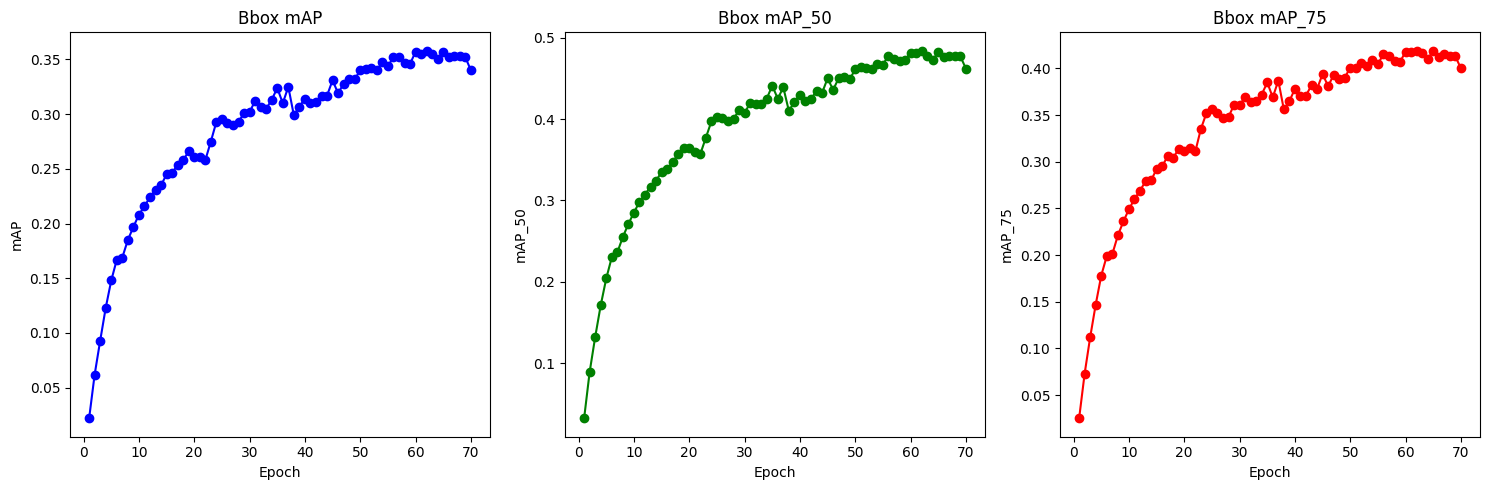

In [ ]:
plot_metrics(df)